In [2]:
import requests
import json
from pyqsartoolbox import QSARToolbox

port_number = 62008  # Change this to the port number given by QSAR Toolbox

The port number can also be found automatically if `psutil` is installed, but running the following code that looks for the listening ports on the local host:  
```python
import requests
from requests.exceptions import RequestException
import psutil
from tqdm import tqdm

def find_open_port(endpoint="/about/toolbox/version"):
    # Get a list of all open ports on localhost with status LISTEN
    open_ports = [conn.laddr.port for conn in psutil.net_connections() if conn.status == "LISTEN" and conn.laddr.ip == "127.0.0.1"]
    
    for port in tqdm(open_ports):
        url = f"http://127.0.0.1:{port}/api/v6{endpoint}"
        try:
            response = requests.get(url, timeout=1)
            if response.status_code == 200:
                return port
        except RequestException:
            continue
    return None

# Example usage
port = find_open_port()
if port:
    print(f"Server found on port {port}")
else:
    print("Server not found within the specified port range")
```

# Calling QSAR Toolbox from Python
The class `QSARToolbox` provides an interface to the web API of the `QSAR Toolbox`. It can be used locally by running the `QSAR Toolbox WebSuite` program that is installed with the `QSAR Toolbox`. After running it, the user can connect to a local host at `http://127.0.0.1:[port]` where the port can be a different value given by the program in the following message:
  > WebAPI running on port [port]  

where [port] is a 4 or 5 digit integer (may be different on your system).

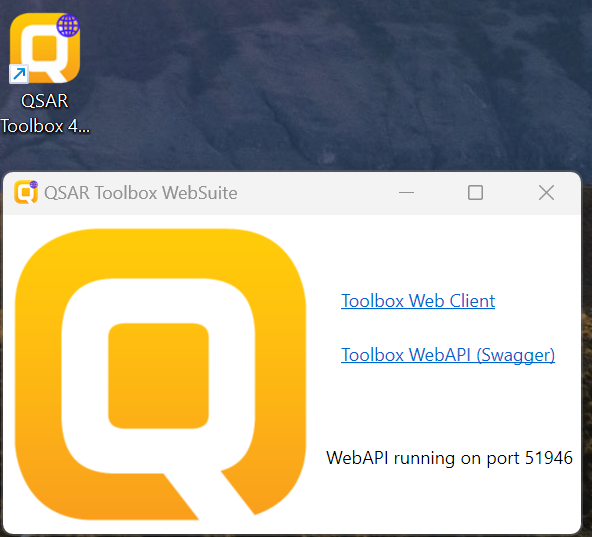

Using the API is quite straightforward with some practical issues that I have discovered and try to clarify in this notebook.

## Installation
The `QSAR Toolbox` can be downloaded for free. I recommend installing `VEGA` and `OPERA` add-ons, which can be downloaded via the toolbox. They will need a working `Java` installation. I have Java on my system and everything worked out of the box. If you encounter any problems, contact me. The package proves can be installed by `pip install proves`.

## Getting started
Start the `QSAR Toolbox WebSuite` and wait for the port number to appear. Then load the package `proves` and create a `QSARToolbox` object:
```python
import proves
qs = proves.QSARToolbox(port=51946)
```

## Search, Data, and Calculations
We will mostly work with three main part of the API:
  . `search` family of methods give us access to the chemical IDs. It is possible to search for chemicals by providing their CAS RN, SMILES, or names. What we often need to get out of the a search call is the `ChemId` that is needed for data retrieval and estimations of endpoints.
  . `data` family of methods are used to get the available experimental data for a specified `ChemId`. 
  . `calculators` are called with a specific `ChemId` and `QSAR model` to estimate an endpoint value.  

The only non-intuitive part of this API is finding the right `QSAR model` for our desired property. We will learn it by practice in the following cells.

## Create the QSARToolbox object

In [3]:
qs = QSARToolbox(port=port_number, timeout=30)

If the local server has not yet started by the user, the above call throws an error. There is a chance that you have a different version of the toolbox and its web API installed. In that case, you can provide the API version as an extra argument to the above code. I have V6 of the API and 4.7 of the toolbox:

In [4]:
api_version = qs.webapi_version()
toolbox_version = qs.toolbox_version()
print(f"API version: {api_version}")
print(f"Toolbox version: {toolbox_version}")

API version: 6
Toolbox version: 4.8


## Search for chemicals
Search can be conducted by CAS, name, SMILES, or ChemID. The ChemID is a long string of the following format `323eca7f-fe36-6959-a6fd-1ae6839278b0`; therefore, it is highly unlikely that someone uses this function. Other identifiers, however, can be used as shown in the following examples.
### Search by name
The name can be specifed as a string and three options of "ExactMatch" (default), "StartWith", and "Contains" are available. It is possible to find multiple chemicals for a specified name; the results are returned as a `list` of `Dict`, with each item referring to a single chemical with a unique `ChemId`.

In [5]:
chem_name = "caffeine"
options = ["ExactMatch", "StartWith", "Contains"]
for option in options:
    res_chem_name = qs.search_name(chem_name, options=option)
    print(f"Found {len(res_chem_name)} chemicals for {option} option")
res_chem_name = qs.search_name(chem_name, options="ExactMatch")
cas_number = [chem["Cas"] for chem in res_chem_name]

Found 4 chemicals for ExactMatch option
Found 29 chemicals for StartWith option
Found 65 chemicals for Contains option


As you can see, the exact match for `caffeine` found fewer results, but more chemicals are found for compund names that starts with or contains the word caffeine.

### Search by CAS and SMILES
The cas number must be an integer without the customary dash, e.g. 50000 instead of "50-00-0" that is the CAS number of formaldehyde. The wrapper function, however, accepts both values.

In [7]:
casrn = "50-00-0"  # formaldehyde
res_chem_cas = qs.search_CAS(casrn)
print(f"Found {len(res_chem_cas)} chemicals for CAS number {casrn}")
print(
    f"The chemical is called {res_chem_cas[0]['Names'][0]}, with SMILES {res_chem_cas[0]['Smiles']}, and ChemId {res_chem_cas[0]['ChemId']}"
)

Found 1 chemicals for CAS number 50-00-0
The chemical is called Formaldehyde, with SMILES C=O, and ChemId 45a89a88-9a20-bfc9-cb55-0aa2c37295f2


In [8]:
smiles = "C=O"  # formaldehyde
res_chem_smiles = qs.search_smiles(smiles)
print(f"Found {len(res_chem_smiles)} chemicals for SMILES {smiles}")

Found 4 chemicals for SMILES C=O


Searching by the `CAS RN` gives a unique answer (note that a CAS RN refers to a unique chemical, but it does not mean that a chemical is identified by a single CASRN. Multiple CAS RN can refer to the same chemical). Searching by `SMILES` can find more than a single chemical, as you can see in the above call with `C=O` that is the `SMILES` string for formaldehyde.

## Data

It is possible to look for the experimental data shipped with the `QSAR Toolbox`. To retrieve data, you need to provide `ChemId` and the end point position from the enpoints tree. The entire end points tree can be obtained by the method `get_endpoints_tree`. It returns a `list` of the available end points:

In [9]:
endpoints_tree = qs.get_endpoints_tree()

In [10]:
endpoints_tree

['Physical Chemical Properties',
 'Environmental Fate and Transport',
 'Ecotoxicological Information',
 'Intermediate effects - mechanistic information',
 'Observed metabolism',
 'Human Health Hazards',
 'Physical Chemical Properties#Autoflammability / Self-ignition temperature',
 'Physical Chemical Properties#Vapour pressure',
 'Physical Chemical Properties#Boiling point',
 'Physical Chemical Properties#Viscosity',
 'Physical Chemical Properties#Oxidation reduction potential',
 'Physical Chemical Properties#Self-reactive substances',
 'Physical Chemical Properties#Surface tension',
 'Physical Chemical Properties#Gases under pressure',
 'Physical Chemical Properties#pH',
 'Physical Chemical Properties#Particle size',
 'Physical Chemical Properties#Flash point',
 'Physical Chemical Properties#Density',
 'Physical Chemical Properties#Solubility in organic solvents / fat solubility',
 'Physical Chemical Properties#Water solubility',
 'Physical Chemical Properties#Oxidising properties',
 '

You then need to look for the desired end point in the tree using the right keyword. For instance, we look for "henry" to find the position of the Henry's law constant in the end points tree. We then need to call another function to find all the available end points for the obtained position:

In [10]:
henry_position = [e for e in endpoints_tree if "henry" in e.lower()]
if len(henry_position) > 0:
    henry_position = henry_position[0]
print(f"Henry position: {henry_position}")
available_henry_endpoints = qs.get_endpoints_from_tree(henry_position)
if len(available_henry_endpoints) > 0:
    available_henry_endpoints = available_henry_endpoints[1]
print(f"Available endpoints: {available_henry_endpoints}")

Henry position: Environmental Fate and Transport#Transport and Distribution#Henry's Law constant (H)
Available endpoints: Henry's Law constant


It is now possible to look for this end point for a specific chemical ID. I repeat the procedure for CAS RN "50-00-0" (formaldehyde):

In [11]:
casrn = "50-00-0"  # formaldehyde
res_chem_cas = qs.search_CAS(casrn)
HLC_value = qs.get_endpoint_data(
    chem_id=res_chem_cas[0]["ChemId"],
    position=henry_position,
    endpoint=available_henry_endpoints,
)
print(f"Henry's law constant experimental value is {(HLC_value[0]['Value'])} {(HLC_value[0]['Unit'])}")

Henry's law constant experimental value is 3.37E-07 atm-m3/mole


There are other ways of looking at the endpoints tree. For instance, one useful way is to get all the endpoints for `Environmental Fate and Transport#Transport and Distribution`. This give all the endpoints available in the databases for the given category:

In [12]:
all_endpoint_transport = qs.get_endpoints_from_tree(
    "Environmental Fate and Transport#Transport and Distribution"
)
print(f"Available endpoints: {all_endpoint_transport}")

Available endpoints: ['distribution modelling', "Henry's law constant", "Henry's Law constant", 'Kd', 'Koc', 'Kos', 'log Kd', 'log Koc', 'monitoring data', 'Other', 'Other Endpoint', None]


And finallym the user can find from which database an end point is extracted. For example, for the Henry's law constant, we can find the name of the database by calling the following method:

In [15]:
pKa_positions = [
    e for e in endpoints_tree if "pka" in e.lower() or "pka" in e.lower()
]
pKa_position = pKa_positions[0] 
available_pKa_endpoints = qs.get_endpoints_from_tree(pKa_position)
for endpoint in available_pKa_endpoints:
    henry_database = qs.get_databases_for_endpoint(
        position=pKa_position, endpoint=endpoint
    )
    print(f"Available databases for {endpoint}: {henry_database}")

Available databases for Acidic pKa: [{'SourceId': 13, 'Caption': 'pKa OASIS', 'Guid': 'adfaec0c-2ee8-892f-7aba-dd2d8554f307'}]
Available databases for dissociation constant: [{'SourceId': 151, 'Caption': 'ECHA REACH', 'Guid': '78dafdfb-fd19-9f04-95f4-ee91fd282c44'}]
Available databases for pKa: [{'SourceId': 54, 'Caption': 'Phys-chem EPISUITE', 'Guid': '15b4a32a-b557-edec-b42e-f1b7db2e0ff7'}]
Available databases for pKa(1): [{'SourceId': 37, 'Caption': 'Experimental pKa', 'Guid': '7ca5bd74-58e1-8ae4-0192-983586b7e697'}]
Available databases for pKa(2): [{'SourceId': 37, 'Caption': 'Experimental pKa', 'Guid': '7ca5bd74-58e1-8ae4-0192-983586b7e697'}]
Available databases for pKa(3): [{'SourceId': 37, 'Caption': 'Experimental pKa', 'Guid': '7ca5bd74-58e1-8ae4-0192-983586b7e697'}]
Available databases for pKa(4): [{'SourceId': 37, 'Caption': 'Experimental pKa', 'Guid': '7ca5bd74-58e1-8ae4-0192-983586b7e697'}]
Available databases for pKa(5): [{'SourceId': 37, 'Caption': 'Experimental pKa', 'Gu

## QSAR
Finally, we can call the available QSAR models for a chemical and an end point position selected from the end point tree.

In [17]:
henry_qsar_models = qs.get_qsar_models(position=henry_position)
print(f"Available QSAR models: {henry_qsar_models}")

HLC_QSAR_list = []
for model in henry_qsar_models:
    HLC_QSAR = {}
    res = qs.apply_qsar_chemical(
        res_chem_cas[0]["ChemId"], qsar_model_guid=model["Guid"]
    )
    HLC_QSAR[model["Caption"]] = res["Value"]
    HLC_QSAR["Unit"] = res["Unit"]
    HLC_QSAR_list.append(HLC_QSAR)
HLC_QSAR_list

Available QSAR models: [{'Caption': 'OPERA HL', 'Guid': '4e0c583d-9bf0-49b7-8f8c-54cdbc026aae', 'Position': "Environmental Fate and Transport#Transport and Distribution#Henry's Law constant (H)#[s]Endpoint:OPERA HL", 'Donator': 'NIEHS/NICEATM'}, {'Caption': 'Henrys Law Constant (Bond Method) (EPISUITE)', 'Guid': '95a49995-2ed8-475d-a905-b2bd9c94c751', 'Position': "Environmental Fate and Transport#Transport and Distribution#Henry's Law constant (H)", 'Donator': 'United States Environmental Protection Agency (EPA), USA'}, {'Caption': 'Henrys Law Constant (Group Method) (EPISUITE)', 'Guid': '6d4090a2-4186-472b-95cb-2ca3130834dc', 'Position': "Environmental Fate and Transport#Transport and Distribution#Henry's Law constant (H)", 'Donator': 'United States Environmental Protection Agency (EPA), USA'}]


[{'OPERA HL': '3.548133892335753E-07', 'Unit': 'atm-m3/mole'},
 {'Henrys Law Constant (Bond Method) (EPISUITE)': '9.29E-05',
  'Unit': 'atm-m3/mole'},
 {'Henrys Law Constant (Group Method) (EPISUITE)': '6.14E-05',
  'Unit': 'atm-m3/mole'}]

The above values are estimated with the available QSAR methods for the Henry's law constant in the QSAR Toolbox. However, there is another way to do it, which is using `calculators`.  
   * __Note__: the OPERA interface takes longer to run (probably for converting SMILES to structure), between 2-5 minutes. Therefore, I suggest not running it from this interface and running it directly from OPERA CLI using the `OPERA_APP` interface in this package.

In [13]:
calculators_list = qs.get_available_calculators()
henry_calculators = []
henry_calculator_values = []
for c in calculators_list:
    if "henry" in c["Caption"].lower():
        h = {}
        h["Caption"] = c["Caption"]
        res = qs.run_calculator(
            calculation_guid=c["Guid"], chem_id=res_chem_cas[0]["ChemId"]
        )
        h["Value"] = res["Value"]
        h["Unit"] = res["Unit"]
        henry_calculator_values.append(h)
        henry_calculators.append(c)
henry_calculator_values

[{'Caption': 'Exp Henrys Law Constant',
  'Value': '3.37E-07',
  'Unit': 'atm-m3/mole'},
 {'Caption': 'Henrys Law Constant (Bond Method)',
  'Value': '9.29E-05',
  'Unit': 'atm-m3/mole'},
 {'Caption': 'Henrys law Constant (Group Method)',
  'Value': '6.14E-05',
  'Unit': 'atm-m3/mole'},
 {'Caption': "Log Koa (Henry's law constant model)",
  'Value': '2.77',
  'Unit': ''}]

One observation is that the `calculators` seem to run faster (TODO: needs more tests; the numbers from the previous calls are cached?)

# How to use it?
The above notes explain most of the functionalities of the module. Here, I wxplain how to use it for a real life example.

## Problem statement
We have a list of compounds identified by their `CAS RN` and `SMILES`. We want to call all the available QSAR models for vapor pressure and also extract the available experimental data. 

### Step 1: extract `ChemId`
First, we look for the `ChemId` for all the compounds, first by searching with `CAS RN`, followed by `SMILES` and potentially `names`.

In [14]:
# water solubility of 50-03-3
chem_by_cas = qs.search_CAS("50-03-3")
chem_id = chem_by_cas[0]["ChemId"]

### Step 2: find the location of endpoint
We get the `endpoint tree` and look for the desired endpoint in it. The goal is to extract the positions in the tree that seem to be relevant to our desired endpoint properties.
  > WARNING: you can find irrelevant values too, depending on the keywords used to search for the endpoints.

In [15]:
endpoints_tree = qs.get_endpoints_tree()
water_solubility_position = [
    e for e in endpoints_tree if "water solubility" in e.lower()
][0]

Here is a graph of the endpoints tree. You can see that searching for, e.g toxicity can lead to multiple positions in the graph.

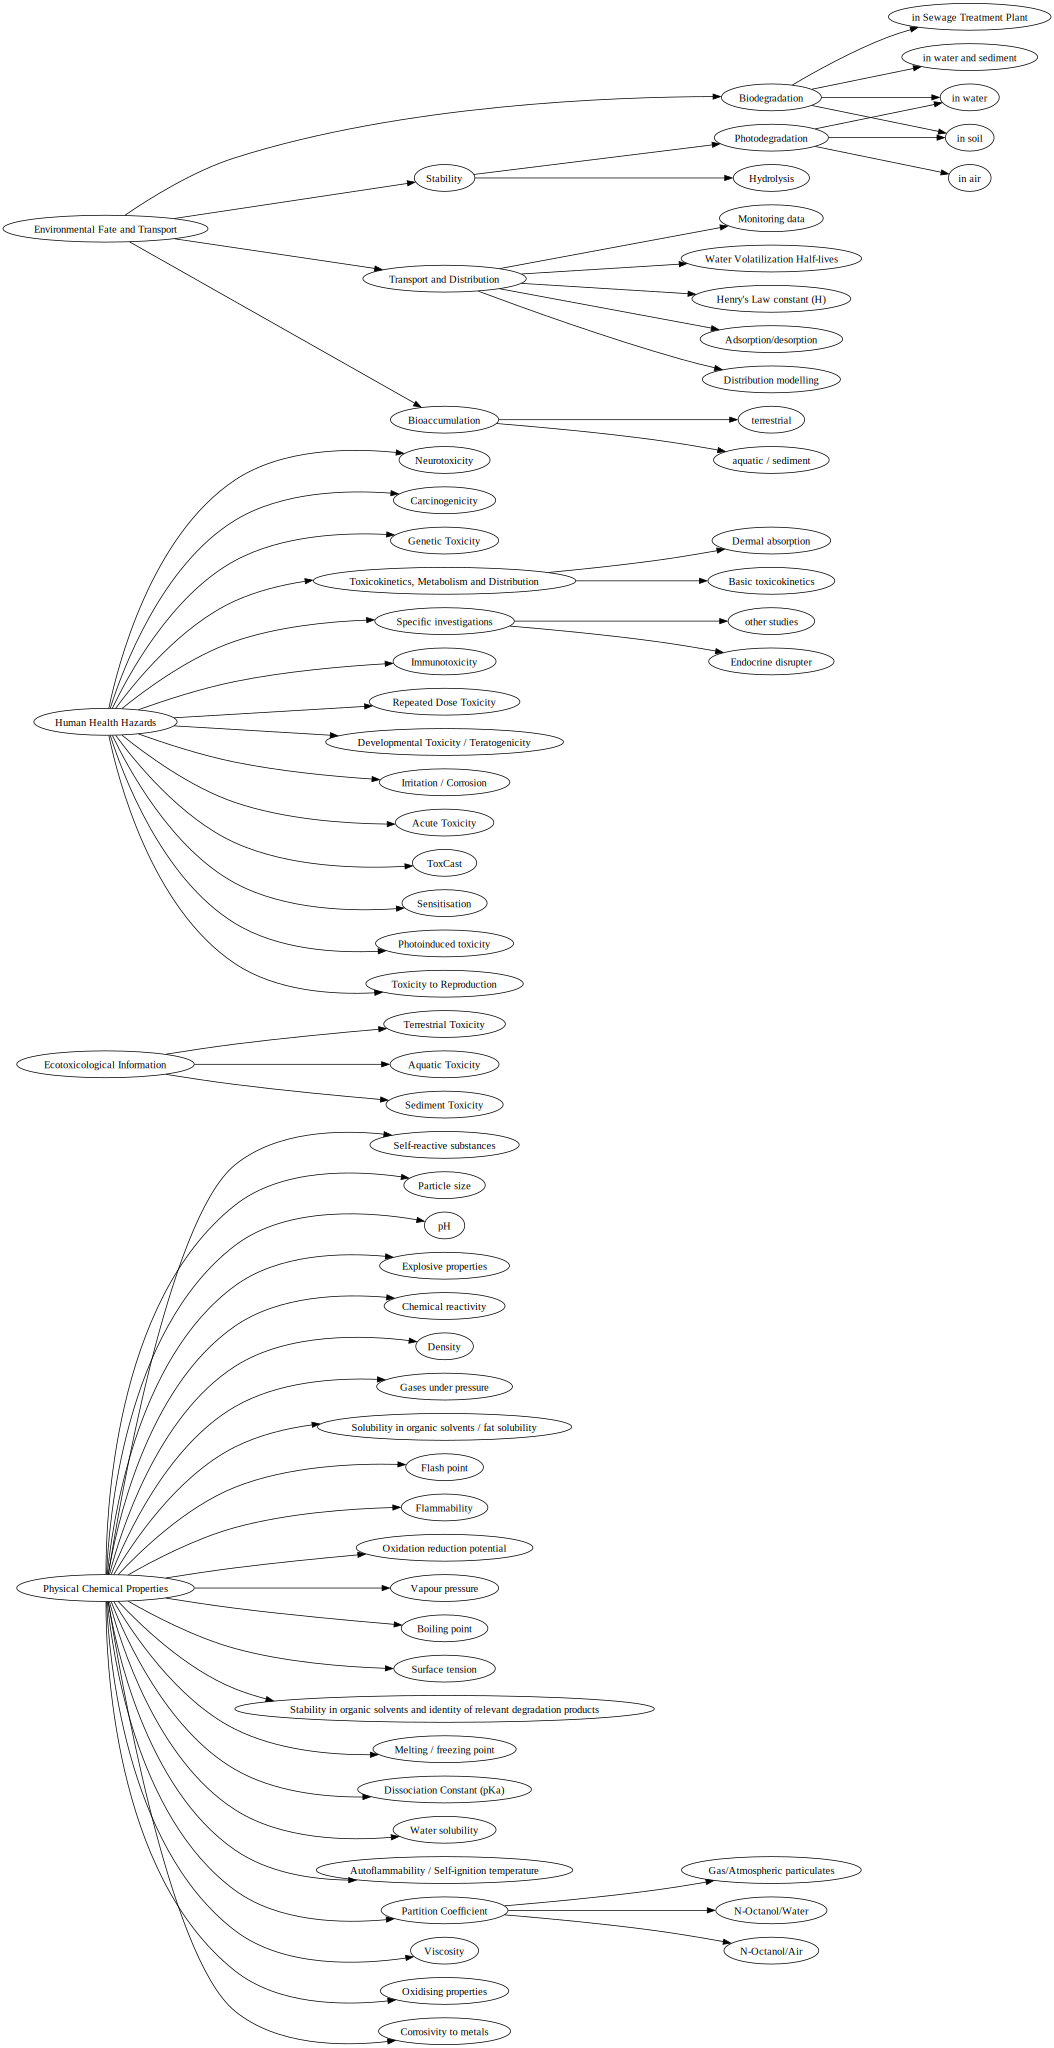

In [6]:
import graphviz
from IPython.display import display


def build_graphviz_tree(endpoints):
    dot = graphviz.Digraph(comment="Endpoints Tree", graph_attr={"rankdir": "LR"})
    edges = set()
    for endpoint in endpoints:
        parts = [part.strip() for part in endpoint.split("#")]
        for i in range(len(parts) - 1):
            edge = (parts[i], parts[i + 1])
            if edge not in edges:
                dot.edge(parts[i], parts[i + 1])
                edges.add(edge)
    return dot


# Example: endpoints_tree contains strings like "Physical Properties#Water Solubility#XYZ"
endpoints_tree = qs.get_endpoints_tree()

# Build the graphviz tree
dot = build_graphviz_tree(endpoints_tree)

# Render and display the graph
dot.render("endpoints_tree", format="png", cleanup=True)
display(dot)

### Step 3: extracting data
After finding the position of the desired endpoint in the tree, we use it to find the available data and models for it. First, we have to get the available endpoint for the selected position in the endpoints tree by calling the method `get_endpoints_from_tree`:

In [17]:
available_water_solubility_endpoints = qs.get_endpoints_from_tree(
    water_solubility_position
)
print("Available endpoints:")
for endpoint in available_water_solubility_endpoints:
    print("  - " + endpoint)

Available endpoints:
  - transformation / dissolution of metals and inorganic metal compounds
  - water solubility
  - Water solubility


As you can see, the first entry does not match what we are looking for (which is the solubility of organic compounds). Therefore, we will only use the last two elements (note the small and capital `W` in water. It becomes important because each one refers to a different dataset!) Here's how we can search for data using the method `get_endpoint_data`:

In [18]:
water_solubility_values = [
    qs.get_endpoint_data(
        chem_id=chem_id,
        position=water_solubility_position,
        endpoint=available_water_solubility_endpoints[i],
    )
    for i in [1, 2]
]
# print each end point dict in the list
for i in range(len(water_solubility_values)):
    print(json.dumps(water_solubility_values[i], indent=2))

[
  {
    "DataType": "Measured value.",
    "RigidPath": "Physical Chemical Properties#Water solubility",
    "Endpoint": "Water solubility",
    "MetaData": null,
    "Value": "14.1",
    "Qualifier": "",
    "MinValue": null,
    "MinQualifier": "",
    "MaxValue": null,
    "MaxQualifier": "",
    "Unit": "mg/L",
    "Family": "Mass concentration"
  }
]
[
  {
    "DataType": "Measured value.",
    "RigidPath": "Physical Chemical Properties#Water solubility",
    "Endpoint": "Water solubility",
    "MetaData": null,
    "Value": "14.1",
    "Qualifier": "",
    "MinValue": null,
    "MinQualifier": "",
    "MaxValue": null,
    "MaxQualifier": "",
    "Unit": "mg/L",
    "Family": "Mass concentration"
  }
]


### Step 4: running QSAR models
The above results are identical for both `water solubility` entries with small and capital `W`. Now, we can find the `QSAR` models for the same endpoints. It is done by calling the method `get_qsar_models`:

In [19]:
# run QSAR model for water solubility
ws_qsar_models = qs.get_qsar_models(position=water_solubility_position)
print(f"Available QSAR models:")
for model in ws_qsar_models:
    print(json.dumps(model, indent=2))

Available QSAR models:
{
  "Caption": "Water Solubility (EPISUITE)",
  "Guid": "a622f86b-c8db-4bcf-8a2e-af849bd1aa2e",
  "Position": "Physical Chemical Properties#Water solubility#[s]Endpoint:Water Solubility",
  "Donator": "United States Environmental Protection Agency (EPA), USA"
}
{
  "Caption": "VEGA - Water solubility model (IRFMN)",
  "Guid": "c8055d19-f4f0-4de9-8a5d-558d56d3b593",
  "Position": "Physical Chemical Properties#Water solubility#[s]Endpoint:Water solubility#[s]Endpoint comment:Water solubility is a measure of the amount of chemical substance that can dissolve in water at a specific temperature.#[s]Assay provider:The model is based on the dataset retrieved from TEST software that consists of 5020 chemicals from the EPISuiteTM database (US EPA. EPI Suite, Version 4.0. US EPA.a, 2019 (accessed 5/21/09)). Chemicals with water solubilities exceeding 1,000,000 mg/L were omitted from the overall dataset. In addition, data were limited to data points that are within 10\u00b0

We can see that four models are available for predicting water solubility: two models from EPI Suite, and one model each for VEGA and OPERA. We can run the models now:

In [20]:
# run the models and time each one
import time

results = []
ws_QSAR_list = []
for model in ws_qsar_models:
    start = time.time()
    res = qs.apply_qsar_chemical(chem_id, qsar_model_guid=model["Guid"])
    results.append(res)
    end = time.time()
    ws_QSAR = {}
    res = qs.apply_qsar_chemical(chem_id, qsar_model_guid=model["Guid"])
    ws_QSAR[model["Caption"]] = res["Value"]
    ws_QSAR["Unit"] = res["Unit"]
    ws_QSAR_list.append(ws_QSAR)
    print(f"Time elapsed for {model['Caption']}: {end-start:.2f} seconds")

Time elapsed for Water Solubility (EPISUITE): 0.06 seconds
Time elapsed for VEGA - Water solubility model (IRFMN): 7.29 seconds
Time elapsed for Water Solubility (fragments) (EPISUITE): 0.03 seconds
Time elapsed for OPERA WS: 28.05 seconds


In [21]:
# print the results
for r in results:
    print(json.dumps(r, indent=2))

{
  "DomainResult": "Undefined",
  "DomainExplain": null,
  "DataType": "Qsar prediction.",
  "RigidPath": "Physical Chemical Properties#Water solubility",
  "Endpoint": "Water Solubility",
  "MetaData": [
    "Prediction approach=External SAR/QSAR",
    "Domain=Undefined (Water Solubility (EPISUITE))",
    "Endpoint=Water Solubility",
    "SAR/(Q)SAR=Water Solubility (EPISUITE) (v1.0)",
    "Domain status=Undefined",
    "Primary group=N/A",
    "Primary group with metabolism=N/A",
    "(Q)SAR options="
  ],
  "Value": "38.71",
  "Qualifier": "",
  "MinValue": null,
  "MinQualifier": "",
  "MaxValue": null,
  "MaxQualifier": "",
  "Unit": "mg/L",
  "Family": "Mass concentration"
}
{
  "DomainResult": "InDomain",
  "DomainExplain": null,
  "DataType": "Qsar prediction.",
  "RigidPath": "Physical Chemical Properties#Water solubility",
  "Endpoint": "Water solubility",
  "MetaData": [
    "VEGA original prediction=3.5139881045453505 -log(mol/L)",
    "VEGA experimental (if found)=4.458",

### Step 4 (alternative): using calculators
Another way of calling `QSAR` model in QSAR Toolbox is using `calculators`. First, we need to get the list of the available calculators:

In [22]:
calculators_list = qs.get_available_calculators()
calculators_list

[{'Caption': 'Calculated heat of formation',
  'Guid': '036e8e9a-cbc8-47d8-b123-c8b5867fbf20',
  'Units': 'kiloCalorie per mole',
  'Is3D': True,
  'IsExperimental': False,
  'Description': 'Heat of formation,[kcal/mol],quantum-chemical descriptor, calculated in OASIS software, based on MOPAC 7. \r\n'},
 {'Caption': 'Diameter effective',
  'Guid': '4d251795-5ce3-4dd9-b51e-fd73b8268815',
  'Units': 'Angstrom',
  'Is3D': True,
  'IsExperimental': False,
  'Description': 'Effective cross-section diameter,[Å], parameter, calculated in OASIS software.\r\n'},
 {'Caption': 'Diameter maximum',
  'Guid': '1804a854-9041-4495-9931-7414c22a5e49',
  'Units': 'Angstrom',
  'Is3D': True,
  'IsExperimental': False,
  'Description': 'Maximum diameter, [Å], parameter, calculated in OASIS software.\r\n'},
 {'Caption': 'Diameter minimum',
  'Guid': '4ea82d5b-449a-4a37-aba1-1205757440ea',
  'Units': 'Angstrom',
  'Is3D': True,
  'IsExperimental': False,
  'Description': 'Minimum diameter, [Å], parameter, c

There are too many of these calculators. We can look for the right one by looking into the 'Caption' or 'Description' of each element. For instance, we can look for 'water solubility':

In [23]:
WS_calculators = []
for c in calculators_list:
    if "water solubility" in c["Caption"].lower():
        WS_calculators.append(c)
WS_calculators

[{'Caption': 'Exp Water Solubility',
  'Guid': '1566ef0c-4ac6-4b0b-aadf-a4f29e8f3367',
  'Units': 'milligram per liter',
  'Is3D': False,
  'IsExperimental': True,
  'Description': 'WSKOWWIN v1.43© 2015 U.S. Environmental Protection AgencyWSKOWWIN is owned by the U.S. Environmental Protection Agency and is protected by copyright throughout the world.Permission is granted for individuals to download and use the software on their personal and business computers.Users may not alter, modify, merge, adapt or prepare derivative works from the software. Users may not remove or obscure copyright, tradename, or proprietary notices on the program or related documentation.WSKOWWIN contained therein is a tradename owned by the U.S. Environmental Protection Agency.'},
 {'Caption': 'Water Solubility',
  'Guid': 'fbdbb4ca-3ece-4047-9c74-6559e4b7fa4d',
  'Units': 'milligram per liter',
  'Is3D': False,
  'IsExperimental': False,
  'Description': 'WSKOWWIN v1.43© 2015 U.S. Environmental Protection Agen

Note that these calculators are only available for the "native" QSAR Toolbox methods and data. The addons (e.g. VEGA and OPERA) are either not part of the calculators or possibly I could not find them. Now, we can call the calculators using the method `run_calculator` for a specified chemical.

In [24]:
WS_values = []
for c in WS_calculators:
    res = qs.run_calculator(calculation_guid=c["Guid"], chem_id=chem_id)
    WS_values.append(res)
WS_values

[{'Value': '14.1',
  'Qualifier': 'None',
  'MinValue': None,
  'MinQualifier': 'None',
  'MaxValue': None,
  'MaxQualifier': 'None',
  'Unit': 'mg/L',
  'Family': 'Mass concentration'},
 {'Value': '38.71',
  'Qualifier': 'None',
  'MinValue': None,
  'MinQualifier': 'None',
  'MaxValue': None,
  'MaxQualifier': 'None',
  'Unit': 'mg/L',
  'Family': 'Mass concentration'},
 {'Value': '24.768',
  'Qualifier': 'None',
  'MinValue': None,
  'MinQualifier': 'None',
  'MaxValue': None,
  'MaxQualifier': 'None',
  'Unit': 'mg/L',
  'Family': 'Mass concentration'}]

The advantage of using `calculators` over the alternative methods is that it is simpler to set up and also faster computationally (based on my limited tests).

## Workflows
There is another option in the QSAR Toolbox called `workflows`. Here's how we can get a list of the available ones:

In [25]:
workflows = qs.get_workflows()
workflows

[{'Caption': 'Skin sensitisation from GPMT assay',
  'Guid': '36d8cd9a-bf22-4d8f-8690-468affb13a39',
  'Endpoint': 'S M W N <OR> Skin sensitisation',
  'RigidPath': 'Human Health Hazards#Sensitisation'},
 {'Caption': 'Fish, LC50(EC50) at 96h for Pimephales promelas (mortality)',
  'Guid': 'ba31e827-bf06-4a27-81ae-56aaa763ce36',
  'Endpoint': 'EC50 <OR> LC50',
  'RigidPath': 'Ecotoxicological Information#Aquatic Toxicity'},
 {'Caption': 'Demo workflow',
  'Guid': '33b163fd-7e42-47f8-b52c-59d911785aa8',
  'Endpoint': None,
  'RigidPath': None},
 {'Caption': 'tb_sys_default_functions',
  'Guid': '8225142f-5c56-4fd5-918e-70a181f0dffb',
  'Endpoint': None,
  'RigidPath': None},
 {'Caption': 'EC3 from LLNA or Skin sensitisation from GPMT assays',
  'Guid': '2a26b617-d8e8-4a32-9dd6-06e983ae44be',
  'Endpoint': 'EC3 <OR> S M W N <OR> Skin sensitisation',
  'RigidPath': 'Human Health Hazards#Sensitisation'},
 {'Caption': 'EC3 from LLNA assay',
  'Guid': '14fe5e12-fec8-4ac1-ba53-1dd9874fe031',
 

It is possible to call the above workflows on a chemical using the method `workflow_on_chemical`.

In [26]:
chem = qs.search_CAS("50-00-0")
chem_id = chem[0]["ChemId"]
print(f"Running workflow {workflows[0]['Caption']} for chemical {chem[0]["Names"][0]}")
res = qs.workflow_on_chemical(workflow_guid=workflows[0]["Guid"], chem_id=chem_id)
res

Running workflow Skin sensitisation from GPMT assay for chemical Formaldehyde


{'Result': 'Positive from " Subcategorized: Protein binding alerts for skin sensitization by OASIS " for C=O',
 'Prediction': {'DomainResult': None,
  'DomainExplain': None,
  'DataType': 'Read-across prediction.',
  'RigidPath': 'Human Health Hazards#Sensitisation',
  'Endpoint': 'S M W N <OR> Skin sensitisation',
  'MetaData': None,
  'Value': 'Positive',
  'Qualifier': None,
  'MinValue': None,
  'MinQualifier': None,
  'MaxValue': None,
  'MaxQualifier': None,
  'Unit': None,
  'Family': None}}

# How to get USEtox input parameters?
We need several parameters for USEtox in their prescribed units:
  - Vapor pressure log(mmHg)
  - Octanol-water partition coefficient (logP)
  - Henry's law constant (log(atm.m^3/mol))
  - Water solubility (log(mg/L))
  - ...

The above parameters can be found either as experimental data (preferred) or as QSAR estimations. The previous sections describes how to get these parameters one by one. For convenience, however, we provide other methods that can take a chemical identifier and return all the required parameters, and even export them to a nicely formatted excel file for use in the USEtox 3 excel files.

In [ ]:
# create an instance of the webapi class
import proves
import rdkit.Chem as Chem
from rdkit.Chem import Descriptors
from thermo import functional_groups as fg
from openpyxl import Workbook  # to write the results to an Excel file
import pandas as pd
import json

port_number = 58054  # this port changes everytime one runs the QSAR Toolbox
qs = QSARToolbox(port=port_number, timeout=30)
cas_rn = "50-00-0"


# usetox_input = qs.get_usetox_input(casrn=cas_rn)

The method `get_usetox_input` goes through the following steps to obtain all the parameters. The `option` parameter can be used to modify the behaviour of this function call. A simplified version of the method is explained here:

In [2]:
chem = qs.search_CAS("50-00-0")
if len(chem) == 0:
    print(f"Chemical with CAS number {cas_rn} not found")
else:
    print(f"Chemical with CAS number {cas_rn} found: {chem[0]['Names'][0]}")
smiles = chem[0]["Smiles"]
name = chem[0]["Names"][0]
chem_id = chem[0]["ChemId"]

Chemical with CAS number 50-00-0 found: Formaldehyde


  > TODO: the `search_smiles` method called with `registerUnknown=True` registers new chemicals. Can it be searched then? Does it get a new chem_id? And can we assign a CASRN and Names to it?

DONE: when searching for a SMILES that cannot be found in the database, if the `registerUnknown=True` is used, then the new SMILES is registered and a ChemId is assigned to it. The CasSmilesRelation will then have a value of 'None'. If `registerUnknown=False` is used, the method throws a `ValueError` (Error: 400). 

### Molecular weight

In [3]:
calculators = qs.get_available_calculators()
for c in calculators:
    if "molecular weight" in c["Caption"].lower():
        MW_calculator = c
        res = qs.run_calculator(calculation_guid=c["Guid"], chem_id=chem[0]["ChemId"])
        MW_value = res["Value"]
        MW_unit = res["Unit"]
        print(f"Molecular weight: {res['Value']} {res['Unit']}")

# get the molecular weight from RDKit
mol = Chem.MolFromSmiles(smiles)
MW_rdkit = Descriptors.MolWt(mol)
print(f"Molecular weight from RDKit: {MW_rdkit}")

Molecular weight: 30.02588 Da
Molecular weight from RDKit: 30.026


### pKa chemical class
Finding out whether the chemical is acid, base, both, or none. For acids, we an use the thermo package that calls rdkit under the hood to obtain the functional groups. For bases, we can use the same package but with our own list of potential organic bases (e.g., amines, amides, etc) as there is no explicit function to determine the basicity of a chemical.

In [4]:
mol = Chem.MolFromSmiles(smiles)
is_acid = fg.is_acid(mol)
print(f"Is {name} an acid? {is_acid}.")

Is Formaldehyde an acid? False.


### pKa and pKb values
For retrieving the pKa data, we can use the following code:

In [5]:
# get the experimental data for the pKa of formaldehyde
endpoints_tree = qs.get_endpoints_tree()
pKa_position = [e for e in endpoints_tree if "pka" in e.lower()][0]  # this index works
available_pKa_endpoints = qs.get_endpoints_from_tree(pKa_position)
print(f"Available endpoints: {available_pKa_endpoints}")

for endpoint in available_pKa_endpoints:
    pKa_values = qs.get_endpoint_data(
        chem_id=chem_id,
        position=pKa_position,
        endpoint=endpoint,
    )
    # skip printing if pKa_values is an empty list
    if len(pKa_values) > 0:
        print(
            f"Experimental pKa value for {endpoint}: {pKa_values[0]['Value']} {pKa_values[0]['Unit']}"
        )

Available endpoints: ['Acidic pKa', 'dissociation constant', 'pKa', 'pKa(1)', 'pKa(2)', 'pKa(3)', 'pKa(4)', 'pKa(5)', 'pKa(6)', 'pKa(7)']
Experimental pKa value for Acidic pKa: 13.27 
Experimental pKa value for pKa: 13.27 
Experimental pKa value for pKa(1): 13.27 


I suggest running the first 4 available endpoints for pKa experimental data. For the QSAR estimations, we use the same end point positions that we got from the endpoint tree. We then get a list of available models for that position and run them. `OPERA` has a model for pKa and pKb. However, I do not recommend running it from its QSAR Toolbox addon, since the processing of the molecular structure takes longer than running it directly in OPERA (especially when running for a group of chemicals). The CLI of OPERA can be called using the `OPERA_APP` class of this package.

In [6]:
# get the QSAR value of pKa and pKb
pKa_qsar_models = qs.get_qsar_models(position=pKa_position)
pka_acidic_models = [
    model for model in pKa_qsar_models if "acidic" in model["Caption"].lower()
]
for model in pka_acidic_models:
    # skip opera
    if "opera" in model["Caption"].lower():
        continue
    print(f"Running model {model['Caption']}")
    res = qs.apply_qsar_chemical(chem_id, qsar_model_guid=model["Guid"])
    print(f"Value: {res['Value']} {res['Unit']}")

pka_basic_models = [
    model for model in pKa_qsar_models if "basic" in model["Caption"].lower()
]
for model in pka_basic_models:
    # skip opera
    if "opera" in model["Caption"].lower():
        continue
    print(f"Running model {model['Caption']}")
    res = qs.apply_qsar_chemical(chem_id, qsar_model_guid=model["Guid"])
    print(f"Value: {res['Value']} {res['Unit']}")

Running model (Q) Acidic pKa (Chemaxon)
Value:  
Running model Acidic pKa (OASIS Electric)
Value: 6.5070589162296795 
Running model Acidic pKa (OASIS Regression)
Value:  
Running model Acidic pKa (OASIS Consensus)
Value:  
Running model (Q) Basic pKa (Chemaxon)
Value: -6.53845600507046 
Running model Basic pKa (OASIS Regression)
Value:  


### Octanol-water partition coefficient
We follow the same procedure as we did for pKa values. Note that what you see here, e.g. the final search keywords that I use to find the `GUID` values for the relevant databases and QSAR models are not from my first attempt and some manual clean up has been involved.

In [7]:
# get the experimental data for the octanol-water partition coefficient of formaldehyde
endpoints_tree = qs.get_endpoints_tree()
logP_position = [e for e in endpoints_tree if "octanol/water" in e.lower()][
    0
]  # this index works
available_logP_endpoints = qs.get_endpoints_from_tree(logP_position)
print(f"Available endpoints: {available_logP_endpoints}")
# manual inspection: only "Log P" is relevant here
logP_values = qs.get_endpoint_data(
    chem_id=chem_id,
    position=logP_position,
    endpoint="Log P",
)
# skip printing if logP_values is an empty list
if len(logP_values) > 0:
    print(logP_values)
    print(
        f"Experimental logP value for logP: {logP_values[0]['Value']} {logP_values[0]['Unit']}"
    )

Available endpoints: ['Log P', 'LogPow', 'partition coefficient']
[{'DataType': 'Measured value.', 'RigidPath': 'Physical Chemical Properties#Partition Coefficient:#N-Octanol/Water', 'Endpoint': 'Log P', 'MetaData': None, 'Value': '0.35', 'Qualifier': '', 'MinValue': None, 'MinQualifier': '', 'MaxValue': None, 'MaxQualifier': '', 'Unit': '', 'Family': 'None'}]
Experimental logP value for logP: 0.35 


I also try one more time with different keyboards since I have installed some new addons for the toolbox:

In [8]:
endpoints_tree = qs.get_endpoints_tree()
logP_position = [e for e in endpoints_tree if "octanol/water" in e.lower()][0]
available_logP_endpoints = qs.get_endpoints_from_tree(logP_position)
for endpoint in available_logP_endpoints:    
    logP_values = qs.get_endpoint_data(
        chem_id=chem_id,
        position=logP_position,
        endpoint=endpoint,
    )
    print(logP_values)

[{'DataType': 'Measured value.', 'RigidPath': 'Physical Chemical Properties#Partition Coefficient:#N-Octanol/Water', 'Endpoint': 'Log P', 'MetaData': None, 'Value': '0.35', 'Qualifier': '', 'MinValue': None, 'MinQualifier': '', 'MaxValue': None, 'MaxQualifier': '', 'Unit': '', 'Family': 'None'}]
[]
[{'DataType': 'Measured value.', 'RigidPath': 'Physical Chemical Properties#Partition Coefficient:#N-Octanol/Water', 'Endpoint': 'partition coefficient', 'MetaData': None, 'Value': '0.35', 'Qualifier': '', 'MinValue': None, 'MinQualifier': '', 'MaxValue': None, 'MaxQualifier': '', 'Unit': '', 'Family': 'None'}]


It seems that not a lot has changed!

Now, we look for the Octanol/water partition coefficient in the QSAR models. Strangely enough, I could not find any QSAR models for the octanol/water partition coefficient. Therefore, I looked into the calculators. After some trial and error, I found the caption `log kow` (in lower case) that is what we are looking for. It is from EPI Suite. I do not know why I cannot find the OPERA and VEGA solvers, or in general why I get an error when I try to get the QSAR models for the partition coefficients.

In [9]:
calculators = qs.get_available_calculators()
logP_calculator = [c for c in calculators if "log kow" == c["Caption"].lower()][0]
logP_value = qs.run_calculator(
    calculation_guid=logP_calculator["Guid"], chem_id=chem_id
)
print(f"LogP value: {logP_value['Value']} {logP_value['Unit']}")

LogP value: 0.35 


### Organic carbon-water partition coefficient
Again, we first look for the data:

In [10]:
endpoints_tree = qs.get_endpoints_tree()
koc_position = [e for e in endpoints_tree if "adsorption" in e.lower()]
get_available_koc_endpoints = qs.get_endpoints_from_tree(koc_position[0])
# remove None values
get_available_koc_endpoints = [e for e in get_available_koc_endpoints if e]
get_available_koc_endpoints = [
    endpoint for endpoint in get_available_koc_endpoints if "Koc" in endpoint
]
print(f"Available endpoints: {get_available_koc_endpoints}")
for endpoint in get_available_koc_endpoints:
    koc_values = qs.get_endpoint_data(
        chem_id=chem_id,
        position=koc_position[0],
        endpoint=endpoint,
    )
    print(json.dumps(koc_values, indent=2))
    # skip printing if koc_values is an empty list
    if len(koc_values) > 0:
        print(
            f"Experimental Koc value for {endpoint}: {koc_values[0]['Value']} {koc_values[0]['Unit']}"
        )

Available endpoints: ['Koc', 'log Koc']
[]
[]


Again, I cannot fint the QSAR models for the adsorption coefficients. Perhaps, I need to look into their subcategories?

In [37]:
calculators = qs.get_available_calculators()
koc_calculator = [c for c in calculators if "koc" in c["Caption"].lower()]
for c in koc_calculator:
    koc_value = qs.run_calculator(calculation_guid=c["Guid"], chem_id=chem_id)
    print(f"Koc value: {koc_value['Value']} {koc_value['Unit']}")

Koc value: 7.752 L/kg
Koc value: 1 L/kg


### Henry's law constant
First, experimental data:

In [38]:
endpoints_tree = qs.get_endpoints_tree()
henry_position = [e for e in endpoints_tree if "henry" in e.lower()][0]
available_henry_endpoints = qs.get_endpoints_from_tree(henry_position)
available_henry_endpoints
for endpoint in available_henry_endpoints:
    henry_values = qs.get_endpoint_data(
        chem_id=chem_id,
        position=henry_position,
        endpoint=endpoint,
    )
    # skip printing if henry_values is an empty list
    if len(henry_values) > 0:
        print(
            f"Experimental Henry value for {endpoint}: {henry_values[0]['Value']} {henry_values[0]['Unit']}"
        )

Experimental Henry value for Henry's law constant: 3.37E-07 atm-m3/mole
Experimental Henry value for Henry's Law constant: 3.37E-07 atm-m3/mole


In [39]:
henry_qsar_models = qs.get_qsar_models(position=henry_position)
for model in henry_qsar_models:
    # skip opera
    if "opera" in model["Caption"].lower():
        continue
    print(f"Running model {model['Caption']}")
    res = qs.apply_qsar_chemical(chem_id, qsar_model_guid=model["Guid"])
    print(f"Value: {res['Value']} {res['Unit']}")

Running model Henrys Law Constant (Group Method) (EPISUITE)
Value: 6.14E-05 atm-m3/mole
Running model Henrys Law Constant (Bond Method) (EPISUITE)
Value: 9.29E-05 atm-m3/mole


### Vapor pressure
The experimental data can be obtained by:

In [40]:
endpoints_tree = qs.get_endpoints_tree()
vp_position = [e for e in endpoints_tree if "vapour pressure" in e.lower()][0]
available_vp_endpoints = qs.get_endpoints_from_tree(vp_position)
for endpoint in available_vp_endpoints:
    vp_values = qs.get_endpoint_data(
        chem_id=chem_id,
        position=vp_position,
        endpoint=endpoint,
    )
    # skip printing if vp_values is an empty list
    if len(vp_values) > 0:
        print(
            f"Experimental vapour pressure value for {endpoint}: {vp_values[0]['Value']} {vp_values[0]['Unit']}"
        )

Experimental vapour pressure value for vapour pressure: 3890 mm Hg
Experimental vapour pressure value for Vapour pressure: 3890 mm Hg


Several methods are available for the calculation of bapor pressure. I skip OPERA again since it takes ages to run, and I have already ran it for the USEtox chemicals.

In [41]:
vp_qsar_models = qs.get_qsar_models(position=vp_position)
for model in vp_qsar_models:
    # skip opera
    if "opera" in model["Caption"].lower():
        continue
    print(f"Running model {model['Caption']}")
    res = qs.apply_qsar_chemical(chem_id, qsar_model_guid=model["Guid"])
    print(f"Value: {res['Value']} {res['Unit']}")

Running model Selected Vapor Pressure (EPISUITE)
Value: 3540 mm Hg
Running model Subcooled liquid Vapor Pressure (EPISUITE)
Value:  mm Hg
Running model Vapor Pressure (Modified Grain Method) (EPISUITE)
Value: 3350 mm Hg
Running model VEGA - Vapour Pressure (CONCERT/Kode)
Value: 7.645577981008425 atm
Running model Vapor Pressure (Antoine Method) (EPISUITE)
Value: 3720 mm Hg
Running model Vapor Pressure (Mackay Method) (EPISUITE)
Value: 3030 mm Hg


### Water solubility
The experimental data can be extracted by the following code:

In [42]:
endpoints_tree = qs.get_endpoints_tree()
ws_position = [e for e in endpoints_tree if "water solubility" in e.lower()][0]
available_ws_endpoints = qs.get_endpoints_from_tree(ws_position)
for endpoint in available_ws_endpoints:
    ws_values = qs.get_endpoint_data(
        chem_id=chem_id,
        position=ws_position,
        endpoint=endpoint,
    )
    # skip printing if ws_values is an empty list
    if len(ws_values) > 0:
        print(
            f"Experimental water solubility value for {endpoint}: {ws_values[0]['Value']} {ws_values[0]['Unit']}"
        )

Experimental water solubility value for water solubility: 400000 mg/L
Experimental water solubility value for Water solubility: 400000 mg/L


And for once, a straightforward running of the QSAR models are done as shown in the following cell. Note that once again we skip `OPERA`.

In [43]:
ws_qsar_models = qs.get_qsar_models(position=ws_position)
for model in ws_qsar_models:
    # skip opera
    if "opera" in model["Caption"].lower():
        continue
    print(f"Running model {model['Caption']}")
    res = qs.apply_qsar_chemical(chem_id, qsar_model_guid=model["Guid"])
    print(f"Value: {res['Value']} {res['Unit']}")

Running model Water Solubility (EPISUITE)
Value: 57020 mg/L
Running model VEGA - Water solubility model (IRFMN)
Value: 3173.008000102647 mg/L
Running model Water Solubility (fragments) (EPISUITE)
Value: 396940 mg/L


Let's change the chemical to something more interesting that is often studied for its environmental impact, biodegradation, and bioaccumulation: 

In [44]:
chem_interesting_cas = "50-32-8"  # thanks to copilot for suggesting it
chem = qs.search_CAS(chem_interesting_cas)
if len(chem) == 0:
    print(f"Chemical with CAS number {chem_interesting_cas} not found")
else:
    print(
        f"Chemical with CAS number {chem_interesting_cas} found: {chem[0]['Names'][3]}"
    )
smiles = chem[0]["Smiles"]
name = chem[0]["Names"][3]
chem_id = chem[0]["ChemId"]

Chemical with CAS number 50-32-8 found: Benzo[a]pyrene


### Degradation half-life in air
Now, I am moving to the uncharted teritory of half-lives. We start by the half-life in air:

In [45]:
endpoints_tree = qs.get_endpoints_tree()
biodeg_position = [e for e in endpoints_tree if "air" in e.lower()][1]
available_biodeg_endpoints = qs.get_endpoints_from_tree(biodeg_position)
for endpoint in available_biodeg_endpoints:
    biodeg_values = qs.get_endpoint_data(
        chem_id=chem_id,
        position=biodeg_position,
        endpoint=endpoint,
    )
    # skip printing if biodeg_values is an empty list
    if len(biodeg_values) > 0:
        print(
            f"Experimental biodegradation value for {endpoint}: {biodeg_values[0]['Value']} {biodeg_values[0]['Unit']}"
        )

Three different degradation in air are reported. For the OH rate constant, we can convert the rate constant to half life by the following relation:
$$t^{1/2} = \frac{0.693}{k_{OH}[OH]}$$
where we can use a value of 1.5e6 molecule/cm^3 per 12 hours of daylight for the $[OH]$ and the value of $k_{OH}$ is in unit cm^3/(molecule.second). 

In [46]:
biodeg_qsar_models = qs.get_qsar_models(position=biodeg_position)
for model in biodeg_qsar_models:
    # skip opera
    if "opera" in model["Caption"].lower():
        continue
    print(f"Running model {model['Caption']}")
    res = qs.apply_qsar_chemical(chem_id, qsar_model_guid=model["Guid"])
    print(f"Value: {res['Value']} {res['Unit']}")

ValueError: Error: 404

### Degradation half-life in water
Another half life this time in water, which is apparently the one that is more available in databases. We find it in the QSAR Toolbox databases using the following code:

In [ ]:
endpoints_tree = qs.get_endpoints_tree()
water_biodeg_position = [
    e for e in endpoints_tree if "water" in e.lower() and "tests" in e.lower()
]

# print the position in a loop
for i in range(len(water_biodeg_position)):
    print(f"Water biodegradation position {i}: {water_biodeg_position[i]}")

available_water_biodeg_endpoints = qs.get_endpoints_from_tree(water_biodeg_position[0])
available_water_biodeg_endpoints = [
    e for e in available_water_biodeg_endpoints if e
]  # remove None values
selected_endpoint_1 = [
    e for e in available_water_biodeg_endpoints if "dt50" in e.lower()
][0]
available_water_biodeg_endpoints = qs.get_endpoints_from_tree(water_biodeg_position[1])
available_water_biodeg_endpoints = [
    e for e in available_water_biodeg_endpoints if e
]  # remove None values
selected_endpoint_2 = [
    e for e in available_water_biodeg_endpoints if "half-life" in e.lower()
][0]
selected_endpoint = [selected_endpoint_1, selected_endpoint_2]
selected_positions = [water_biodeg_position[0], water_biodeg_position[1]]

print(f"Selected endpoint: {selected_endpoint}")
print(f"Selected positions: {selected_positions}")
for position, endpoint in zip(selected_positions, selected_endpoint):
    water_biodeg_values = qs.get_endpoint_data(
        chem_id=chem_id,
        position=position,
        endpoint=endpoint,
    )
    print(json.dumps(water_biodeg_values, indent=2))
    # skip printing if water_biodeg_values is an empty list
    if len(water_biodeg_values) > 0:
        print(
            f"Experimental biodegradation value for {endpoint}: {water_biodeg_values[0]['Value']} {water_biodeg_values[0]['Unit']}"
        )

Water biodegradation position 0: Environmental Fate and Transport#Biodegradation#in water and sediment: simulation tests
Water biodegradation position 1: Environmental Fate and Transport#Biodegradation#in water: screening tests
Selected endpoint: ['DT50', 'half-life in days (QSAR/QSPR)']
Selected positions: ['Environmental Fate and Transport#Biodegradation#in water and sediment: simulation tests', 'Environmental Fate and Transport#Biodegradation#in water: screening tests']
[]
[]


Many different data can be obtained but only a few are quantitative. I finaly selected two of them that give the half-lives in days. For the QSAR, we follow the following procedure. This one is also a bit difficult to choose. We have several different options to run. I have, however, manually listed the following QSAR models.

In [ ]:
water_biodeg_qsar_models = qs.get_qsar_models(position=water_biodeg_position[0])
# print the models
for model in water_biodeg_qsar_models:
    print(json.dumps(model, indent=2))
selected_qsar_model = [
    model
    for model in water_biodeg_qsar_models
    if "Persistence (water) quantitative" in model["Caption"]
][0]

print(f"Running model {selected_qsar_model['Caption']}")
res = qs.apply_qsar_chemical(chem_id, qsar_model_guid=selected_qsar_model["Guid"])
print(res)
print(f"Value: {res['Value']} {res['Unit']}")

{
  "Caption": "VEGA - Persistence (water) quantitative model (IRFMN)",
  "Guid": "b19a3738-0465-4473-bfea-9792698da139",
  "Position": "Environmental Fate and Transport#Biodegradation#in water and sediment: simulation tests#[s]Endpoint:Persistence#[s]Test type:Aerobic Mineralisation in Surface Water \u00c2\u20ac\u201c Simulation Biodegradation Test#[s]Test guideline:OECD 309#[s]Reference:Gouin, T., Cousins, I., Mackay, D., 2004. Comparison of two methods for obtaining degradation half-lives. Chemosphere 56, 531\u00e2\u20ac\u201c535#[s]Reference Link:10.1016/j.chemosphere.2004.04.018#[s]R2(Train):0.89#[s]RMSE(Train):0.28#[s]R2(Test):0.84#[s]RMSE(Test):0.34",
  "Donator": "Istituto di Ricerche Farmacologiche Mario Negri"
}
{
  "Caption": "VEGA - Persistence (water) model (IRFMN)",
  "Guid": "dc35f380-4ef1-496d-9375-84f077e61255",
  "Position": "Environmental Fate and Transport#Biodegradation#in water and sediment: simulation tests#[s]Endpoint:Persistence#[s]Test type:Aerobic Mineralisat

We have a look at the calculators too:

In [ ]:
calculators = qs.get_available_calculators()
water_biodeg_calculators = [c for c in calculators if "half" in c["Caption"].lower()]
for c in water_biodeg_calculators:
    res = qs.run_calculator(calculation_guid=c["Guid"], chem_id=chem_id)
    # check the applicability domain
    # try:
    #     res_applicability = qs.applicability_domain_qsar_chemical(
    #         chem_id=chem_id, qsar_model_guid=c["Guid"]
    #     )
    #     print(res_applicability)
    # except:
    #     print(f"Applicability domain not available for calculator {c['Caption']}")
    print(f"Value: {res['Value']} {res['Unit']} from calculator {c['Caption']}")

Value: 0.9037 d from calculator Bio Half-Life
Value: 421.6 d from calculator BioHC Half-Life
Value: 0.904 d from calculator Biotransformation Half-Life
Value: 5.13 h from calculator FM half-life air
Value: 13000 h from calculator FM half-life sediment
Value: 2880 h from calculator FM half-life soil
Value: 1440 h from calculator FM half-life water
Value: 931.3 d from calculator Half-Life (Model Lake)
Value: 84.86 d from calculator Half-Life (Model River)
Value: None min from calculator Half-Life (Observed metabolism)
Value: None d from calculator Hydrolysis half-life (pH 6.5-7.4)
Value: None yr from calculator Ka Half-Life (pH 7)
Value: None yr from calculator Ka Half-Life (pH 8)
Value: None yr from calculator Kb half-life (pH 7)
Value: None yr from calculator Kb half-life (pH 8)
Value: 0.214 d from calculator OVERALL OH Half-life
Value: None d from calculator OVERALL OZONE Half-life


### Degradation half-life in sediment
For sediment, we more or less follow the previous procedure for the half-life in water.

In [ ]:
endpoints_tree = qs.get_endpoints_tree()
biodeg_position = [
    e for e in endpoints_tree if "sediment" in e.lower() and "degrad" in e.lower()
][0]
available_biodeg_endpoints = qs.get_endpoints_from_tree(biodeg_position)
available_biodeg_endpoints = [e for e in available_biodeg_endpoints if e]
selected_sediment_endpoint = [
    e for e in available_biodeg_endpoints if "dt50" in e.lower()
][0]
selected_sediment_position = biodeg_position
print(f"Selected endpoint: {selected_sediment_endpoint}")
print(f"Selected position: {selected_sediment_position}")
biodeg_values = qs.get_endpoint_data(
    chem_id=chem_id,
    position=selected_sediment_position,
    endpoint=selected_sediment_endpoint,
)
print(json.dumps(biodeg_values, indent=2))

Selected endpoint: DT50
Selected position: Environmental Fate and Transport#Biodegradation#in water and sediment: simulation tests
[]


If there is no data for the selected endpoint and chemical, an empty list is returned. Again, we look into the calculators and QSAR models

In [ ]:
biodeg_qsar_models = qs.get_qsar_models(position=selected_sediment_position)
selected_qsar_model = [
    model
    for model in biodeg_qsar_models
    if "Persistence (sediment) quantitative" in model["Caption"]
][0]

print(f"Running model {selected_qsar_model['Caption']}")
res = qs.apply_qsar_chemical(chem_id, qsar_model_guid=selected_qsar_model["Guid"])
print(f"The sediment half-life is {res['Value']} {res['Unit']}")
print(res)

Running model VEGA - Persistence (sediment) quantitative model (IRFMN)
The sediment half-life is 2291.659027081501 d
{'DomainResult': 'InDomain', 'DomainExplain': None, 'DataType': 'Qsar prediction.', 'RigidPath': 'Environmental Fate and Transport#Biodegradation#in water and sediment: simulation tests', 'Endpoint': 'Persistence', 'MetaData': ['VEGA original prediction=3.36015 log(days)', 'VEGA experimental (if found)=3.36', 'VEGA reliability class=GOOD reliability', 'VEGA Assessment=2292 days (EXPERIMENTAL value)', 'Domain=In domain (VEGA - Persistence (sediment) quantitative model (IRFMN))', 'Endpoint=Persistence', 'Test type=Aerobic and Anaerobic Transformation in Aquatic Sediment Systems', 'Test guideline=OECD 308', 'Reference=Gouin, T., Cousins, I., Mackay, D., 2004. Comparison of two methods for obtaining degradation half-lives. Chemosphere 56, 531â€“535', 'Reference Link=10.1016/j.chemosphere.2004.04.018', 'R2(Train)=0.89', 'RMSE(Train)=0.28', 'R2(Test)=0.84', 'RMSE(Test)=0.34', 

In [ ]:
# calculators for sediment
calculators = qs.get_available_calculators()
sediment_calculators = [
    c for c in calculators if "half-life sediment" in c["Caption"].lower()
][0]
res = qs.run_calculator(calculation_guid=sediment_calculators["Guid"], chem_id=chem_id)
print(f"The sediment half-life is {res['Value']} {res['Unit']}")
print(res)

The sediment half-life is 13000 h
{'Value': '13000', 'Qualifier': 'None', 'MinValue': None, 'MinQualifier': 'None', 'MaxValue': None, 'MaxQualifier': 'None', 'Unit': 'h', 'Family': 'Time'}


### Degradation half-life in soil
And, finally the half life in soil. First, available data:

In [ ]:
endpoints_tree = qs.get_endpoints_tree()
biodeg_position = [
    e for e in endpoints_tree if "soil" in e.lower() and "degrad" in e.lower()
][0]
available_biodeg_endpoints = qs.get_endpoints_from_tree(biodeg_position)
# remove None values
available_biodeg_endpoints = [e for e in available_biodeg_endpoints if e]
selected_soil_endpoint = [e for e in available_biodeg_endpoints if "dt50" in e.lower()][
    0
]
selected_soil_position = biodeg_position
print(f"Selected endpoint: {selected_soil_endpoint}")
print(f"Selected position: {selected_soil_position}")
biodeg_values = qs.get_endpoint_data(
    chem_id=chem_id,
    position=selected_soil_position,
    endpoint=selected_soil_endpoint,
)
print(json.dumps(biodeg_values, indent=2))
if len(biodeg_values) > 0:
    print(
        f"Experimental biodegradation value for {selected_soil_endpoint}: {biodeg_values[0]['Value']} {biodeg_values[0]['Unit']}"
    )

Selected endpoint: DT50
Selected position: Environmental Fate and Transport#Biodegradation#in soil
[]


And the QSAR models and calculators:

In [ ]:
bio_soil_qsar_models = qs.get_qsar_models(position=selected_soil_position)
selected_qsar_model = [
    model
    for model in bio_soil_qsar_models
    if "Persistence (soil) quantitative" in model["Caption"]
][0]

print(f"Running model {selected_qsar_model['Caption']}")
res = qs.apply_qsar_chemical(chem_id, qsar_model_guid=selected_qsar_model["Guid"])
if len(res) > 0:
    print(f"The soil half-life is {res['Value']} {res['Unit']}")
print(res)

Running model VEGA - Persistence (soil) quantitative model (IRFMN)
The soil half-life is 708.337117801943 d
{'DomainResult': 'OutOfDomain', 'DomainExplain': None, 'DataType': 'Qsar prediction.', 'RigidPath': 'Environmental Fate and Transport#Biodegradation#in soil', 'Endpoint': 'Persistence', 'MetaData': ['VEGA original prediction=2.85024 log(days)', 'VEGA experimental (if found)=2.85', 'VEGA reliability class=LOW reliability', 'VEGA Assessment=708 days (EXPERIMENTAL value)', 'Domain=Out of domain (VEGA - Persistence (soil) quantitative model (IRFMN))', 'Endpoint=Persistence', 'Test type=Aerobic and Anaerobic Transformation in Soil', 'Test guideline=OECD 307', 'Reference=Gouin, T., Cousins, I., Mackay, D., 2004. Comparison of two methods for obtaining degradation half-lives. Chemosphere 56, 531â€“535', 'Reference Link=10.1016/j.chemosphere.2004.04.018', 'R2(Train)=0.96', 'RMSE(Train)=0.17', 'R2(Test)=0.67', 'RMSE(Test)=0.48', 'SAR/(Q)SAR=VEGA - Persistence (soil) quantitative model (IR

In [ ]:
calculators = qs.get_available_calculators()
soil_calculators = [c for c in calculators if "half-life soil" in c["Caption"].lower()][
    0
]
res = qs.run_calculator(calculation_guid=soil_calculators["Guid"], chem_id=chem_id)
if len(res) > 0:
    print(f"The soil half-life is {res['Value']} {res['Unit']}")
print(res)

The soil half-life is 2880 h
{'Value': '2880', 'Qualifier': 'None', 'MinValue': None, 'MinQualifier': 'None', 'MaxValue': None, 'MaxQualifier': 'None', 'Unit': 'h', 'Family': 'Time'}


### Dissipation half-life in above-ground plant tissues
~~I am not sure about this one but I will give it a shot.~~  
As expected, I could not find any values for this one. I will discuss it with the group tomorrow.

In [ ]:
endpoints_tree = qs.get_endpoints_tree()
biodeg_position = [e for e in endpoints_tree if "dis" in e.lower()]
biodeg_position

['Physical Chemical Properties#Dissociation Constant (pKa)',
 'Physical Chemical Properties#Oxidising properties',
 'Human Health Hazards#Toxicokinetics, Metabolism and Distribution',
 'Human Health Hazards#Toxicokinetics, Metabolism and Distribution#Dermal absorption',
 'Human Health Hazards#Toxicokinetics, Metabolism and Distribution#Basic toxicokinetics',
 'Human Health Hazards#Specific investigations#Endocrine disrupter',
 'Environmental Fate and Transport#Transport and Distribution',
 'Environmental Fate and Transport#Transport and Distribution#Distribution modelling',
 'Environmental Fate and Transport#Transport and Distribution#Water Volatilization Half-lives',
 'Environmental Fate and Transport#Transport and Distribution#Monitoring data',
 "Environmental Fate and Transport#Transport and Distribution#Henry's Law constant (H)",
 'Environmental Fate and Transport#Transport and Distribution#Adsorption/desorption']

In [ ]:
available_biodeg_endpoints = qs.get_endpoints_from_tree(biodeg_position[11])
available_biodeg_endpoints

['Kd', 'Koc', 'Kos', 'log Kd', 'log Koc', 'Other', 'Other Endpoint', None]

In [ ]:
# look into calculators
calculators = qs.get_available_calculators()
biodeg_calculators = [c for c in calculators if "degr" in c["Caption"].lower()]
biodeg_calculators

[{'Caption': 'Ready Biodegradability Prediction',
  'Guid': '8a60f10c-d448-415f-80e7-2410234d2dc3',
  'Units': '',
  'Is3D': False,
  'IsExperimental': False,
  'Description': 'BIOWIN v4.11© 2017 U.S. Environmental Protection AgencyBIOWIN is owned by the U.S. Environmental Protection Agency and is protected by copyright throughout the world.Permission is granted for individuals to download and use the software on their personal and business computers.Users may not alter, modify, merge, adapt or prepare derivative works from the software. Users may not remove or obscure copyright, tradename, or proprietary notices on the program or related documentation.IOWIN contained therein is a tradename owned by the U.S. Environmental Protection Agency.Biowin1 = Linear ModelThe Linear Biodegradation Probability of a chemical is calculated by summing the values (fragment coefficients) of each fragment and then adding the summation to a constant coefficient.A Probability Greater Than or Equal to 0.5 

### Bioaccumulation factor in fish
The bioaccumulation factor (BAF? BCF?) is the one that must be accessible

In [ ]:
import numpy as np

endpoints_tree = qs.get_endpoints_tree()
bioaccumulation_endpoints = [e for e in endpoints_tree if "bioacc" in e.lower()]
endpoint_position = qs.get_endpoints_from_tree(bioaccumulation_endpoints[1])

res = qs.get_endpoint_data(
    chem_id=chem_id,
    position=bioaccumulation_endpoints[1],
    endpoint=endpoint_position[-2],
)
res_val = []
for r in res:
    # check for the unit L/kg or log(L/kg); throw away other units
    if r["Unit"].lower() == "l/kg":
        res_val.append(float(r["Value"]))
    elif r["Unit"].lower() == "log(l/kg)":
        res_val.append(10 ** float(r["Value"]))
    else:
        continue
# calculate the average and sd of the res_val
res_val = np.array(res_val)
avg = np.mean(res_val)
sd = np.std(res_val)
geo_mean = np.exp(np.mean(np.log(res_val)))
sd_geo = np.exp(np.std(np.log(res_val)))
print(f"Experimental bioaccumulation value: {avg} ± {sd} L/kg")
print(f"Geometric mean: {geo_mean} ± {sd_geo} L/kg")

['Environmental Fate and Transport#Bioaccumulation',
 'Environmental Fate and Transport#Bioaccumulation#aquatic / sediment',
 'Environmental Fate and Transport#Bioaccumulation#terrestrial']

Sometimes, too many data points can be obtained. In these cases, I simply average the values and report their geometric mean. The QSAR models can also be called for estimating the bioaccumulation factor:

In [ ]:
try:
    bioaccumulation_qsar_models = qs.get_qsar_models(
        position=bioaccumulation_endpoints[1]
    )
except:
    print("No QSAR models for bioaccumulation can be retrieved due to a 404 error")

No QSAR models available for bioaccumulation can be retrieved due to a 404 error


In [ ]:
# look for calculators
calculators = qs.get_available_calculators()
bioaccumulation_calculators = [c for c in calculators if "bcf" in c["Caption"].lower()]
bioaccumulation_calculators
for c in bioaccumulation_calculators:
    res = qs.run_calculator(calculation_guid=c["Guid"], chem_id=chem_id)
    print(f"Value: {res['Value']} {res['Unit']} from calculator {c['Caption']}")

Value: 3.71 log(L/kg) from calculator BCF
Value: 2.74 log(L/kg) from calculator BCF (lower trophic)
Value: 2.699 log(L/kg) from calculator BCF (mid trophic)
Value: 4.322 log(L/kg) from calculator BCF (upper trophic, biotransformation rate is zero)
Value: 2.561 log(L/kg) from calculator BCF (upper trophic)
Value: 4.393528461456299 log(L/kg wet) from calculator log BCF max


# A deeper look at the endpoints tree
I have installed all the available addons and must -theoretically- have access to more data and QSAR models, if they are available via the Web API.

In [ ]:
endpoints_tree = qs.get_endpoints_tree()
endpoints_tree

['Environmental Fate and Transport',
 'Ecotoxicological Information',
 'Intermediate effects - mechanistic information',
 'Physical Chemical Properties',
 'Human Health Hazards',
 'Environmental Fate and Transport#Stability',
 'Environmental Fate and Transport#Bioaccumulation',
 'Environmental Fate and Transport#Transport and Distribution',
 'Environmental Fate and Transport#Biodegradation',
 'Environmental Fate and Transport#Stability#Photodegradation',
 'Environmental Fate and Transport#Stability#Hydrolysis',
 'Environmental Fate and Transport#Stability#Photodegradation#in water',
 'Environmental Fate and Transport#Stability#Photodegradation#in soil',
 'Environmental Fate and Transport#Stability#Photodegradation#in air',
 'Environmental Fate and Transport#Bioaccumulation#aquatic / sediment',
 'Environmental Fate and Transport#Bioaccumulation#terrestrial',
 "Environmental Fate and Transport#Transport and Distribution#Henry's Law constant (H)",
 'Environmental Fate and Transport#Transp

We have quite a lot more endpoints available now. 

In [ ]:
chem_interesting_cas = "50-32-8"  # thanks to copilot for suggesting it
chem = qs.search_CAS(chem_interesting_cas)
if len(chem) == 0:
    print(f"Chemical with CAS number {chem_interesting_cas} not found")
else:
    print(
        f"Chemical with CAS number {chem_interesting_cas} found: {chem[0]['Names'][3]}"
    )
smiles = chem[0]["Smiles"]
name = chem[0]["Names"][3]
chem_id = chem[0]["ChemId"]

endpoints_position = [e for e in endpoints_tree if "accumu" in e.lower()]
print(f"Desired endpoints: {endpoints_position}")
for endpoint in endpoints_position:
    available_endpoints = qs.get_endpoints_from_tree(endpoint)
    for baf_endpoints in available_endpoints:
        if baf_endpoints is None:
            continue
        res = qs.get_endpoint_data(
            chem_id=chem_id,
            position=endpoint,
            endpoint=baf_endpoints,
        )
        for r in res:
            try:
                print(f"{r['Endpoint']}: {r['Value']} {r['Unit']}")
            except:
                print("results not available")


Chemical with CAS number 50-32-8 found: Benzo[a]pyrene
Desired endpoints: ['Environmental Fate and Transport#Bioaccumulation', 'Environmental Fate and Transport#Bioaccumulation#aquatic / sediment', 'Environmental Fate and Transport#Bioaccumulation#terrestrial']
kM Half-Life: 0.0474921610451384 log(Days)
kM: 1.0927846733815896 1/Days
kM: 0.3442182154652885 1/Days
kM: 0.6369918433349516 1/Days
BCFD: 7000 L/kg
BCFD: 14000 L/kg
BCFD: 130 L/kg
BCFD: 8000 L/kg
BCFD: 770 L/kg
BCFD: 120000 L/kg
BCFD: 23000 L/kg
BCFD: 310000 L/kg
BCFD: 90 L/kg
BCFD: 1600 L/kg
BCF: 2.5763413502057935 log(L/kg)
BCF: 2.6901960800285143 log(L/kg)
BCF: 2.9253330558266915 log(L/kg)
BCF: 3.3636119798921444 log(L/kg)
BCF: 3.424391554410278 log(L/kg)
BCF: 4.3 log(L/kg)
BCF: 4.380211241711606 log(L/kg)
BCF: 4.6020599913279625 log(L/kg)
BCF: 4.690196080028515 log(L/kg)
BCF: 4.785329835010767 log(L/kg)
BCF: 4.792391689498254 log(L/kg)
BCF: 4.886490725172482 log(L/kg)
BCF: 4.919078092376074 log(L/kg)
BCF: 5.029383777685211 